# Montecarlo calculation for Lennard Jones potential

## Lennard Jones potential
$V(r)=4(\frac{1}{r^{12}}-\frac{1}{r^6})$

In [6]:
import numpy as np
import matplotlib.pyplot as plt

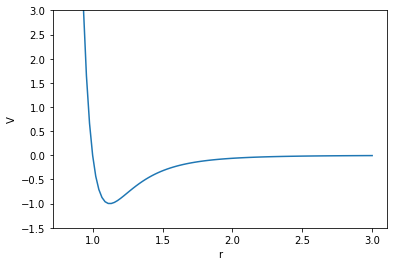

In [37]:
x=np.linspace(0.8,3, 100)[1:]
y=4*(1/x**12-1/x**6)

plt.plot(x,y)
plt.xlabel('r')
plt.ylabel('V')
plt.ylim(-1.5, 3)
plt.show()

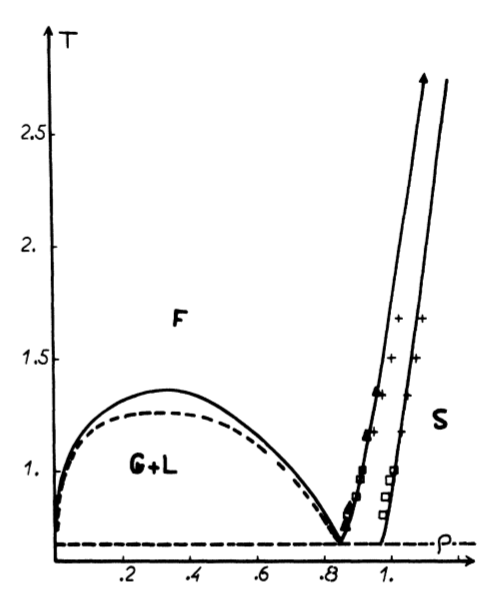

In [8]:
from IPython.display import Image
Image("phasediag.png")

## Utilities

Definition of data type to store simulation data

In [9]:
dt = np.dtype([('BETA', np.float64), ('MCTIME', np.float64), ('VIRIAL1', np.float64), ('DELTA', np.float64),
               ('ENERGY', np.float64), ('N1', np.int32), ('L', np.float64), ('ACCEPTANCE', np.float64),
               ('ENERGYSQUARE', np.float64), ('TEMPERATURE', np.float64), ('DENSITY', np.float64),
               ('PRESSURE', np.float64),('CV', np.float64), ('ENERGYERR', np.float64), ('CVERR', np.float64),
               ('N', np.int32), ('THERMTIME', np.int32), ('THBIN', np.int32), ('BTIME', np.int32),
               ('VOLUME', np.float64), ('PRERR', np.float64), ('ENERGYTAIL', np.float64), ('VIRTAIL', np.float64),
               ('CUTOFF', np.float64), ('U', np.float64), ('TOTENERGY', np.float64), ('DELTAIN', np.float64),
               ('FILENAME', np.unicode_, 32), ('SIMTIME', np.float64), ('CORRTIME', np.float64)])
print(dt.fields.keys())

dict_keys(['BETA', 'MCTIME', 'VIRIAL1', 'DELTA', 'ENERGY', 'N1', 'L', 'ACCEPTANCE', 'ENERGYSQUARE', 'TEMPERATURE', 'DENSITY', 'PRESSURE', 'CV', 'ENERGYERR', 'CVERR', 'N', 'THERMTIME', 'THBIN', 'BTIME', 'VOLUME', 'PRERR', 'ENERGYTAIL', 'VIRTAIL', 'CUTOFF', 'U', 'TOTENERGY', 'DELTAIN', 'FILENAME', 'SIMTIME', 'CORRTIME'])


Functions for input/output

In [10]:
def deltaf(rho, T): # suitable value of trial step 
    delta = 0.12+0.01*T-0.1*rho
    if delta>0.02: return delta
    else: return 0.02

In [11]:
import re
import glob

# Read commented lines of the format '# NAME value' from file .out and return a structured array
def get_data(file):
    d = np.zeros([], dtype=dt)
    with open(file) as f:
        for line in f:
            try:
                m = re.match("# (\S+) ([-+]?\d+.\d+e[+-]?\d+)", line)
                d[m.group(1)]=float(m.group(2))
            except:
                try:
                    m = re.match("# (\S+) ([-+]?\d+.\d+)", line)
                    d[m.group(1)]=float(m.group(2))
                except:
                    try:
                        m = re.match("# (\S+) (\d+)", line)
                        d[m.group(1)]=int(m.group(2))
                    except: pass
    return d    

Functions for binning/error bar analysis

In [12]:
# get s^2 and its error bar (using jackknife) given the array and the binning
def binjk(arra, binning):
    binnum=int(len(arra)/binning)
    red_arr = np.reshape(arra, (binning, binnum), order='F').mean(axis=0)
    jk= (np.sum(red_arr**2)-red_arr**2)/binnum/(binnum-2)-(np.sum(red_arr)-red_arr)**2/binnum/(binnum-1)/(binnum-2)
    return np.mean(jk), np.sqrt(np.var(jk)*(binnum-1))

# get error bar for specific heat using jackknife
def bincvjk(ens, en, binning):
    binnum=int(len(ens)/binning)
    red_en = np.reshape(en, (binning, binnum), order='F').mean(axis=0)
    red_ens = np.reshape(ens, (binning, binnum), order='F').mean(axis=0)
    cvjk = (np.sum(red_ens)-red_ens)/(binnum-1)+(np.sum(red_en**2)-red_en**2)/(binnum*(binnum-1)*(binnum-2))\
    -(np.sum(red_en)-red_en)**2/(binnum*(binnum-2))
    return np.var(cvjk)*(binnum-1)

npbintec=np.vectorize(binjk, signature='(n),()->(),()')
npbincvjk=np.vectorize(bincvjk, signature='(n),(n),()->()')

In [13]:
# get saturation value of a curve, with weighted average

seqlen=12 # number of consecutive points to test constant fit
exclen=3 # number of initial points to exclude from the average

def get_satval(values, errors):
    chisq=100
    i=-1
    weights=1/errors**2
    while chisq>seqlen-1: 
        if i>len(values)-seqlen: return np.nan, np.nan, np.nan
        else:
            i+=1
            avg=np.average(values[i:i+seqlen], weights=weights[i:i+seqlen])
            chisq=np.sum((values[i:i+seqlen]-avg)**2*weights[i:i+seqlen])
    avg=np.average(values[i+exclen:i+seqlen], weights=weights[i+exclen:i+seqlen], returned=True)
    return avg[0], 1/np.sqrt(avg[1]), i        

In [14]:
# read file .out, get error bars using binning technique + jackknife and 
# return all data collected in a variable of type dt

def get_mcdata(file):
    d=get_data(file)
    arr=np.genfromtxt(file, usemask=True, delimiter='\t')
    indmax=int(2*d['THERMTIME']/d['THBIN'])
    energyth, virth, rhokth = np.transpose(arr[:indmax])
    energybin, ensqbin, virbin =np.transpose(arr[indmax:])
    d['ENERGY'] = np.mean(energybin)
    d['VIRIAL1'] = np.mean(virbin)
    d['ENERGYSQUARE'] = np.mean(ensqbin)
    d['TEMPERATURE']=1/d['BETA']
    d['VOLUME']=d['L']**3
    d['N']=d['N1']**3
    d['DENSITY'] = (d['N1']/d['L'])**3
    d['CUTOFF']=d['L']/2
    d['ENERGYTAIL']=(8*np.pi/3)*d['DENSITY']*(d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
    d['VIRTAIL']=(16*np.pi/3)*d['DENSITY']*(2*d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
    d['PRESSURE']=(d['TEMPERATURE']+d['VIRIAL1']+d['VIRTAIL'])*d['DENSITY']
    d['U']=d['ENERGY']+d['ENERGYTAIL']
    d['TOTENERGY']=d['U']+1.5*d['TEMPERATURE']
    d['CV']=d['BETA']**2*(d['ENERGYSQUARE']-d['ENERGY']**2)
    d['FILENAME']=file
    
    bins = np.array([i for i in range(1,70) if int(d['MCTIME']/d['BTIME'])%i==0])
    resen=npbintec(energybin, bins)
    respr=npbintec(virbin, bins)
    reses=npbintec(ensqbin, bins)
    rescv=npbincvjk(ensqbin, energybin, bins)
    
    s_en=get_satval(resen[0], resen[1])
    d['ENERGYERR']=np.sqrt(s_en[0])

    s_pr=get_satval(respr[0], respr[1])
    d['PRERR']=np.sqrt(s_pr[0])
    
    if not np.isnan(s_en[2]):
        i=int(s_en[2])
        vec=rescv[i+exclen : i+seqlen]
        d['CVERR']=d['BETA']**2*np.sqrt(np.average(rescv[i+exclen : i+seqlen], \
               weights=1/(resen[1][i+exclen:i+seqlen])**2))
    else: d['CVERR']=np.nan
    d['CORRTIME']=d['ENERGYERR']**2*d['MCTIME']*d['BETA']**2/d['CV']
    return d

Functions for Maxwell construction

In [15]:
#from scipy.integrate import simps

def trap_area(x, y, ysec=None):
    #return simps(y, x, even='last')
    if ysec is None: return np.sum((y[1:]+y[:-1])*(x[1:]-x[:-1])/2)
    else:
        dA=np.maximum(ysec[1:], ysec[:-1])*np.diff(x)**3/12
        return np.sum((y[1:]+y[:-1])*(x[1:]-x[:-1])/2), np.sum(dA**2)
        #Atrap=np.sum((y[1:]+y[:-1])*(x[1:]-x[:-1])/2)
        #xex=np.concatenate(([x[0]], x, [x[-1]]))
        #xm=(xex[2:]-xex[0:-2])/2
        #Arect=np.sum(xm*y)
        #Asimps=simps(y, x, even='last')
        #Areas=np.array([Arect, Atrap, Asimps])
        #return np.mean(Areas), np.var(Areas)


def maxwell_func(Parr, Varr, P, T, Perr=0, P0err=0):
    index=np.argmax(Parr<P)
    V0=(Varr[index-1]-Varr[index])*(P-Parr[index])/(Parr[index-1]-Parr[index])+Varr[index]
    if Parr[-1]<P:
        rind=np.where(Parr>P)[0][-1]
        Vlast=(Varr[rind+1]-Varr[rind])*(P-Parr[rind])/(Parr[rind+1]-Parr[rind])+Varr[rind]
        newP=np.append(P, np.append(Parr[index:rind+1], P))
        newV=np.append(V0, np.append(Varr[index:rind+1], Vlast))
        if len(newP>1) and index>0:
            Psec=np.abs(((Parr[index+1:rind+2]-Parr[index:rind+1])/(Varr[index+1:rind+2]-Varr[index:rind+1])-
                  (Parr[index:rind+1]-Parr[index-1:rind])/(Varr[index:rind+1]-Varr[index-1:rind]))*2/
                        (Varr[index+1:rind+2]-Varr[index-1:rind]))
            Psec=np.concatenate(([0],Psec,[0]))

            newPerr=np.zeros((len(newP)+2))
            dAdP=np.zeros((len(newP)+2))
            dAdP[0]+=(P+Parr[index])*(V0-Varr[index])/2/(Parr[index-1]-Parr[index])
            dAdP[1]+=-(P+Parr[index])*(Varr[index-1]-Varr[index])/2/(Parr[index-1]-Parr[index])
            dAdP[2]+=-(P+Parr[index])*(V0-Varr[index-1])/2/(Parr[index-1]-Parr[index])
            dAdP[-1]+=(P+Parr[rind])*(Vlast-Varr[rind])/2/(Parr[rind+1]-Parr[rind])
            dAdP[-2]+=-(P+Parr[rind])*(Varr[rind+1]-Varr[rind])/2/(Parr[rind+1]-Parr[rind])
            dAdP[-3]+=-(P+Parr[rind])*(Vlast-Varr[rind+1])/2/(Parr[rind+1]-Parr[rind])
            dAdP[1:-2]+=(newV[1:]-newV[:-1])/2
            dAdP[2:-1]+=(newV[1:]-newV[:-1])/2
            newPerr[0]=Perr[index-1]
            newPerr[-1]=Perr[rind+1]
            newPerr[1]=P0err
            newPerr[-2]=P0err
            newPerr[2:-2]=Perr[index:rind+1]
            A, varA=trap_area(newV, newP-P, Psec)
            dA= np.sqrt(np.sum((dAdP*newPerr)**2)+varA)
        else:
            A = trap_area(newV, newP-P)
            dA=np.nan

        
        return A, V0, Vlast, dA
    else:
        newP=np.append(P, Parr[index:])
        newV=np.append(V0, Varr[index:])
        
        if len(newP)>1 and index>0:
            Psec=np.abs(((Parr[index+1:]-Parr[index:-1])/(Varr[index+1:]-Varr[index:-1])-
                  (Parr[index:-1]-Parr[index-1:-2])/(Varr[index:-1]-Varr[index-1:-2]))*2/
                        (Varr[index+1:]-Varr[index-1:-2]))
            Psec=np.concatenate(([0],Psec,[0]))

            newPerr=np.zeros((len(newP)+1))
            dAdP=np.zeros((len(newP)+1))
            dAdP[0]+=(P+Parr[index])*(V0-Varr[index])/2/(Parr[index-1]-Parr[index])
            dAdP[1]+=-(P+Parr[index])*(Varr[index-1]-Varr[index])/2/(Parr[index-1]-Parr[index])
            dAdP[2]+=-(P+Parr[index])*(V0-Varr[index-1])/2/(Parr[index-1]-Parr[index])
            dAdP[1:-1]+=(newV[1:]-newV[:-1])/2
            dAdP[2:]+=(newV[1:]-newV[:-1])/2
            newPerr[0]=Perr[index-1]
            newPerr[1]=P0err
            newPerr[2:]=Perr[index:]
            A, varA=trap_area(newV, newP-P, Psec)
            dA=np.sqrt(np.sum((dAdP*newPerr)**2)+varA)
        else:
            A = trap_area(newV, newP-P)
            dA=np.nan
        
        return A+T*np.log(T/P/Varr[-1])-T+P*Varr[-1], V0, T/P, dA

def maxwell_construction(P, V, T, Perr=0, P0err=0.00001):
    Pmax=np.amax(P)
    Pmin=max(np.amin(P),0)
    Pfl=np.flip(P,0)
    Vfl=np.flip(V,0)
    Amax=0
    Amin=0
    Vmax=[0,0]
    Vmin=[0,0]
    while Pmax-Pmin>0.000001:
        Ptest=(Pmax+Pmin)/2
        res=maxwell_func(Pfl, Vfl, Ptest, T, Perr=Perr, P0err=0.00001)
        if res[0]>0:
            Pmin=Ptest
            Amax=res[0]
            Vmax=[res[1], res[2]]
        else:
            Pmax=Ptest
            Amin=res[0]
            Vmin=[res[1], res[2]]
    dP=res[3]*np.abs((Pmax-Pmin)/(Amax-Amin))
    dVl=dP*np.abs((Vmax[0]-Vmin[0])/(Pmax-Pmin))
    dVr=dP*np.abs((Vmax[1]-Vmin[1])/(Pmax-Pmin))
    return Ptest, res[1], res[2], dP, dVl, dVr
    

## Monte Carlo Simulation

### Equilibration time

In [139]:
file = './data/first/test1.out'#, './data/phasediag2/test0085.out'
simdata = get_mcdata(file)

arr=np.genfromtxt(file, usemask=True, delimiter='\t')
indmax=int(2*simdata['THERMTIME']/simdata['THBIN'])
energyth, virth, rhokth = np.transpose(arr[:indmax])
energybin, ensqbin, virbin =np.transpose(arr[indmax:])

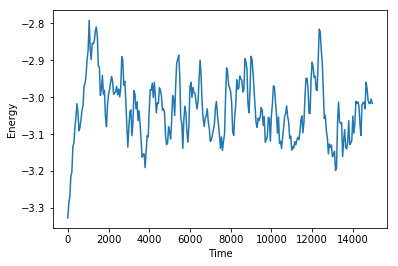

In [140]:
f, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(simdata['THBIN']*np.arange(len(rhokth)),energyth)
ax.set_xlabel('Time')
ax.set_ylabel('Energy')

plt.show()

In [141]:
file_2 = './data/phasediag2/test0085.out'
simdata_2 = get_mcdata(file_2)

arr_2=np.genfromtxt(file_2, usemask=True, delimiter='\t')
indmax_2=int(2*simdata_2['THERMTIME']/simdata_2['THBIN'])
energyth, virth, rhokth = np.transpose(arr_2[:indmax_2])

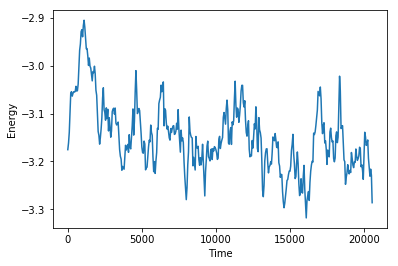

In [142]:
f, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(simdata_2['THBIN']*np.arange(len(rhokth)),energyth)
ax.set_xlabel('Time')
ax.set_ylabel('Energy')

plt.show()

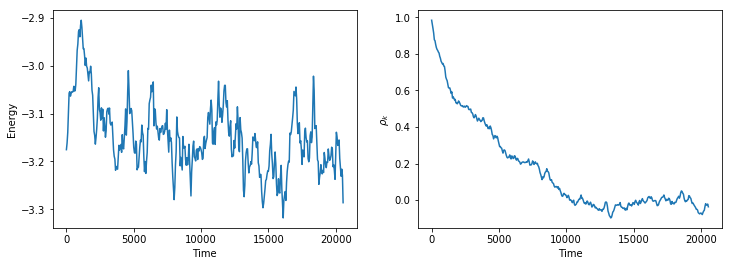

In [143]:
f, axarr = plt.subplots(1,2,figsize=(12,4))

#for file in glob.glob('./data/*.out'):
axarr[0].plot(simdata_2['THBIN']*np.arange(len(rhokth)),energyth)
axarr[1].plot(simdata_2['THBIN']*np.arange(len(rhokth)),rhokth)

axarr[0].set_xlabel('Time')
axarr[0].set_ylabel('Energy')
axarr[1].set_xlabel('Time')
axarr[1].set_ylabel(r'$\rho_k$')

plt.show()

### Error bars

In [153]:
bins = np.array([i for i in range(1,60) if int(simdata['MCTIME']/simdata['BTIME'])%i==0])
resen=npbintec(energybin, bins)
respr=npbintec(virbin, bins)
reses=npbintec(ensqbin, bins)
rescv=npbincvjk(ensqbin, energybin, bins)
  
s_en=get_satval(resen[0], resen[1])
saten=s_en[0]

s_pr=get_satval(respr[0], respr[1])
satpr=s_pr[0]

i=int(s_en[2])
vec=rescv[i+exclen : i+seqlen]
satcv=simdata['BETA']**4*(np.average(rescv[i+exclen : i+seqlen], \
           weights=1/(resen[1][i+exclen:i+seqlen])**2))

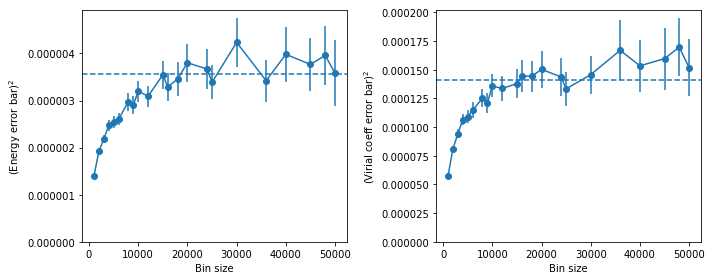

In [154]:
f, axarr = plt.subplots(1,2,figsize=(10,4))

axarr[0].errorbar(bins*simdata['BTIME'], resen[0], marker='o', yerr=resen[1], label = r'$\beta=$%.2f' % simdata['BETA'])
axarr[0].axhline(y=saten, color='C0', linestyle='dashed')
axarr[1].errorbar(bins*simdata['BTIME'], respr[0], marker='o', yerr=respr[1], label = r'$\beta=$%.2f' % simdata['BETA'])
axarr[1].axhline(y=satpr, color='C0', linestyle='dashed')
#axarr[2].plot(bins*simdata['BTIME'], simdata['BETA']**4*rescv, marker='o', label = r'$\beta=$%.2f' % simdata['BETA'])
#axarr[2].axhline(y=satcv, color='C0', linestyle='dashed')

axarr[0].set_ylabel(r'(Energy error bar$)^2$')
axarr[1].set_ylabel(r'(Virial coeff error bar$)^2$')
#axarr[2].set_ylabel(r'(Specific heat error bar$)^2$')

for ax in axarr:
    ax.set_xlabel('Bin size')
    ax.set_ylim(ymin=0)

plt.tight_layout()
plt.show()

## Phase diagram

In [16]:
## read files and create datasets

# dataset1=np.empty(0, dtype=dt)

# for file in np.roll(np.sort(glob.glob('./data/phasediag2/*.out')),16):
#     d=get_mcdata(file)
#     dataset1=np.append(dataset1, d)

# dataset2=np.empty(0, dtype=dt)

# for file in np.roll(np.sort(glob.glob('./data/phasediag3/*.out')),16):
#     d=get_mcdata(file)
#     dataset2=np.append(dataset2, d)
    
# datasets=[dataset1, dataset2]

In [17]:
## write datasets to files

# fileres = open('./data/phasediag2/resnew.dat','w') 
# fileres.write('# ')
# for name in dt.names: fileres.write(name+' ') 
# fileres.write('\n')
# for index, i in enumerate(dataset1):
#     for j in i:
#         fileres.write(str(j)+' ')
#     fileres.write('\n')   
# fileres.close()

# fileres = open('./data/phasediag3/resnew.dat','w') 
# fileres.write('# ')
# for name in dt.names: fileres.write(name+' ') 
# fileres.write('\n')
# for index, i in enumerate(dataset2):
#     for j in i:
#         fileres.write(str(j)+' ')
#     fileres.write('\n')   
# fileres.close()

In [109]:
# read datasets from files
ds1=np.genfromtxt('./data/phasediag2/resnew.dat', dtype=dt, names=True)
ds2=np.genfromtxt('./data/phasediag3/resnew.dat', dtype=dt, names=True)
#print(ds1['THERMTIME'])
#print(ds2['THERMTIME'])

In [19]:
phaseseplist=[]
tottime=0

# do Maxwell construction

for dataset in [ds1,ds2]:
    myds=dataset.view().reshape((19,8))
    

    for i in range(8): 
        T=myds[0, i]['TEMPERATURE']
        P0,Vl,Vr, dP0, dVl, dVr =maxwell_construction(myds[:, i]['PRESSURE'][1:],
                                                      1/myds[:, i]['DENSITY'][1:], T, Perr=myds[:, i]['PRERR'][1:])
        phaseseplist.append(np.array([T, P0, 1/Vr, 1/Vl, dP0, dVr/Vr**2, dVl/Vl**2]))
    #count total number of simulation steps
    tottime+=np.sum(myds[:,:]['MCTIME'])+np.sum(myds[:,:]['THERMTIME'])
phasesep=np.array(phaseseplist)


/u/cm/fsurace/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in double_scalars


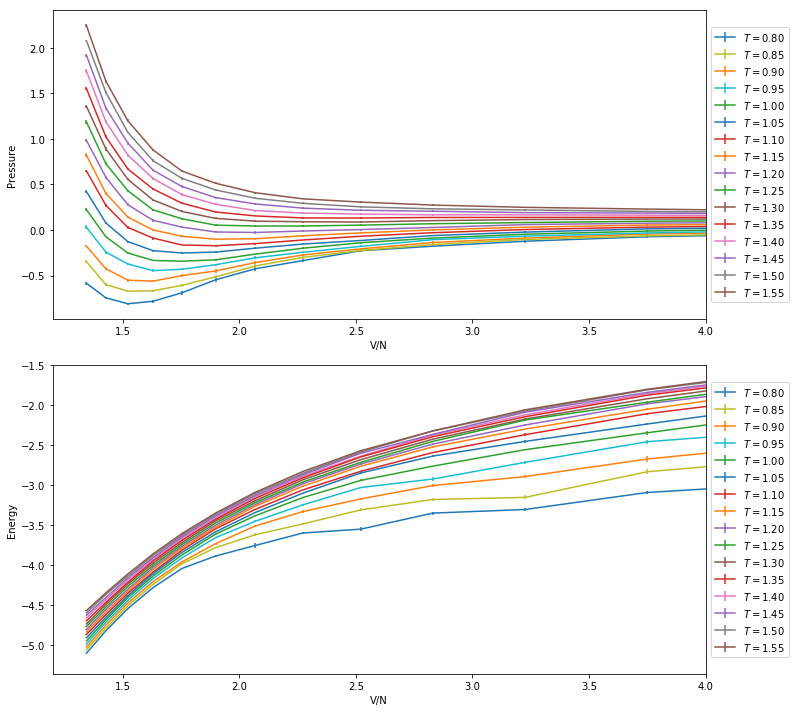

In [20]:
#Plot
fpv, axarrpv = plt.subplots(2,1,figsize=(10,10))

for dataset in [ds1,ds2]:
    myds=dataset.view().reshape((19,8))
    
    for i in range(8):
        T=myds[0, i]['TEMPERATURE']
        axarrpv[0].errorbar(1/myds[:, i]['DENSITY'], myds[:, i]['PRESSURE'], 
                            yerr=myds[:, i]['PRERR'], label= r'$T=$%.2f' % T)
        axarrpv[1].errorbar(1/myds[:, i]['DENSITY'], myds[:,i]['ENERGY'],
                            yerr=myds[:, i]['ENERGYERR'], label= r'$T=$%.2f' % T)
    
for ax in axarrpv:
    ax.legend()
    ax.set_xlim(xmin=1.2, xmax=4)
    ax.set_xlabel("V/N")
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
axarrpv[0].set_ylabel("Pressure")
axarrpv[1].set_ylabel("Energy")
axarrpv[1].set_ylim(ymax=-1.5)
plt.tight_layout()

plt.show()

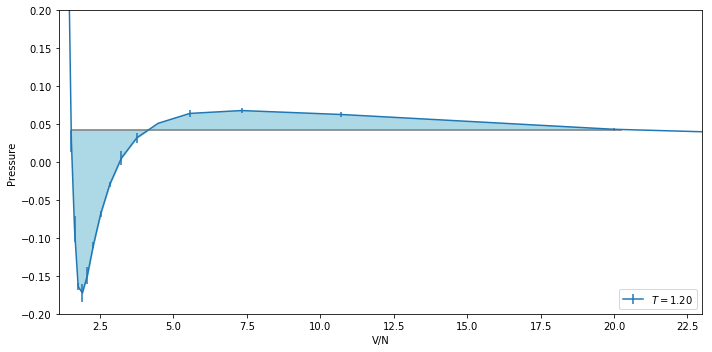

In [21]:
# Plot Maxwell construction

fmc, axmc = plt.subplots(1,1,figsize=(10,5))

myds=ds1.view().reshape((19,8))
i=3
T=myds[0, 4]['TEMPERATURE']
axmc.errorbar(1/myds[:, i]['DENSITY'], myds[:, i]['PRESSURE'],
              yerr=myds[:, i]['PRERR'], label= r'$T=$%.2f' % T)

        
P0,Vl,Vr, dP0, dVl, dVr =maxwell_construction(myds[:, i]['PRESSURE'][1:], 1/myds[:, i]['DENSITY'][1:],
                                              T, Perr=myds[:, i]['PRERR'][1:])
mask=np.argwhere((1/myds[:, i]['DENSITY']>Vl) & (1/myds[:, i]['DENSITY']<Vr))
Vma = 1/myds[:, i]['DENSITY'][mask][:,0]
Pma =myds[:, i]['PRESSURE'][mask][:,0]
axmc.fill_between(Vma, Pma, P0, color='lightblue')


axmc.legend(loc='lower right')
axmc.set_xlim(xmin=1.1, xmax=23)
axmc.set_ylim(ymin=-0.2, ymax=0.2)
axmc.hlines(y=P0, xmin=Vl, xmax=Vr, color='C7')
axmc.set_xlabel("V/N")


axmc.set_ylabel("Pressure")
plt.tight_layout()

plt.show()

In [24]:
jtab=np.loadtxt('./JohnsonData.txt', unpack=True)

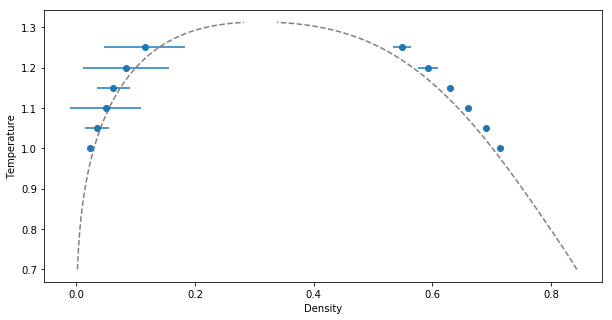

In [25]:
fpd, axarrpd = plt.subplots(1,1,figsize=(10,5))

ps=phasesep[[2,3,4,10,11,12]]

axarrpd.plot(jtab[1], jtab[0], linestyle='dashed', color='grey')
axarrpd.errorbar(ps[:,2], ps[:,0], xerr=ps[:,5], marker='o', linestyle='', color='C0')
axarrpd.plot(jtab[2], jtab[0], linestyle='dashed', color='grey')
axarrpd.errorbar(ps[:,3], ps[:,0], xerr=ps[:,6], marker='o', linestyle='', color='C0')

axarrpd.set_ylabel('Temperature')
axarrpd.set_xlabel('Density')

plt.show()

In [41]:
seconds=22*tottime/3600000 #total second needed
hours=seconds/3600
print("Getting this result for the phase diagram required a total time of %.2f hours of simulation." %hours)

Getting this result for the phase diagram required a total time of 3.80 hours of simulation.


## Size scaling

In [ ]:
# counter=0

# rho=0.5
# beta=0.5


# for N1 in range(5,15):
#     L1= rho**(-1/3)*N1
#     delta = deltaf(rho,1/beta)
#     file = open('./data/size_scaling/test%04d.in' % counter,'w') 
#     file.write("N1      %d\nL       %.8f\nDELTAIN %.4f\nBETA    %.8f\nMCTIME  3600000\
#     \nBTIME   10000\nTHBIN   50\n" % (N1, L1, delta, beta))
#     file.close()
#     counter+=1

In [26]:
dataset=np.empty(0, dtype=dt)

for file in np.sort(glob.glob('./data/size_scaling/*.out')):
    d=get_mcdata(file)
    dataset=np.append(dataset, d)

In [27]:
print(dataset['SIMTIME'])

[  22.   38.   59.   82.  117.  165.  206.  263.  332.  399.   21.   35.
   56.   88.  123.  176.  196.  251.  313.  387.   21.   38.   59.   83.
  113.  157.  268.  287.  317.  383.   20.   35.   56.   83.  117.  157.
  200.  255.  318.  385.   21.   35.   56.   84.  116.  157.  201.  256.
  317.  390.]


In [28]:
Nds=dataset.view().reshape((5,10))


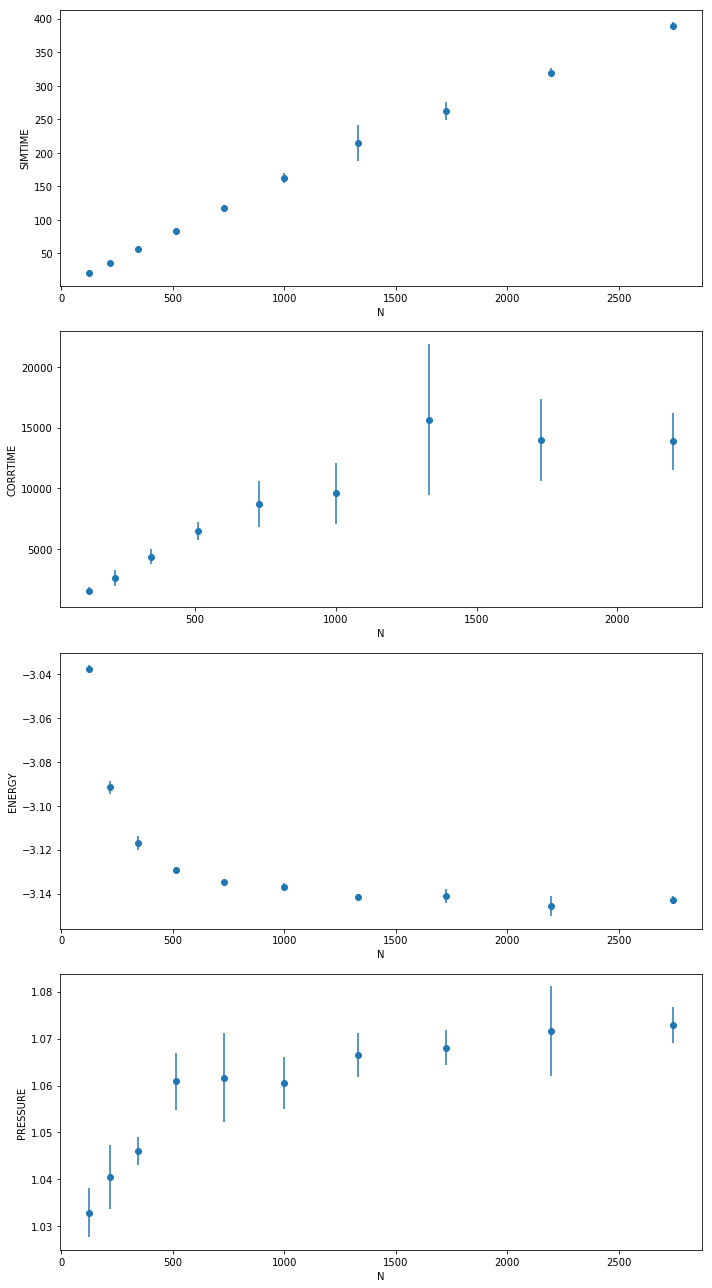

In [32]:
names=['SIMTIME', 'CORRTIME', 'ENERGY', 'PRESSURE']

f, axarr = plt.subplots(len(names),1,figsize=(10,18))

for i, name in enumerate(names):
    axarr[i].errorbar(Nds[0, :]['N'], np.mean(Nds[name], axis=0), 
                      yerr=np.std(Nds[name], axis=0), marker='o', linestyle='')
    axarr[i].set_xlabel('N')
    axarr[i].set_ylabel(name)
#axarr[2].errorbar(Nds[0, :]['N'], Nds[0, :]['ENERGY'], yerr=Nds[0, :]['ENERGYERR'], marker='o', linestyle='')
#axarr[3].errorbar(Nds[0, :]['N'], Nds[0, :]['PRESSURE'], yerr=Nds[0, :]['PRERR'], marker='o', linestyle='')
plt.tight_layout()

plt.show()